# Notebook to show how to analyse the highschool dataset

In [2]:
import networkx as nx
import numpy as np
import sklearn
import yaml


In [4]:
from pathlib import Path
from pgm.input.loader import import_data

root_dir = Path.cwd().parent.parent.parent.resolve()
in_folder = root_dir / 'pgm' / 'data' / 'input'
adj = Path('highschool_data.dat')
network = in_folder / adj  # network complete path

A, B, B_T, data_T_vals = import_data(network, ego='source', alter='target', undirected=False,
                                     force_dense=False, noselfloop=True, verbose=True, binary=True, header=0)
nodes = A[0].nodes()


/home/dtheuerkauf/toolkit/prob-gen-model-for-nets/pgm/data/input/highschool_data.dat shape: (100, 3)
Creating the network ... Removing self loops

Number of nodes = 31
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 100 - <k> = 6.452
Sparsity [0] = 0.104
Reciprocity (networkX) = 0.52
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.351

Reciprocity (considering the weights of the edges) = 0.52


In [5]:
# setting to run the algorithm
algorithm = 'JointCRep'
config_path = 'setting_' + algorithm + '.yaml'

In [6]:
import importlib.resources as res

with res.open_binary('pgm.data.model', config_path) as fp:
    conf = yaml.load(fp, Loader=yaml.Loader)

In [7]:
# Print the configuration file
print(yaml.dump(conf))

K: 2
assortative: false
end_file: _test
eta0: null
files: ../data/input/theta.npz
fix_communities: false
fix_eta: false
fix_w: false
initialization: 0
out_folder: outputs/
out_inference: true
plot_loglik: false
rseed: 10
use_approximation: false


In [8]:
# Change the output folder
conf['out_folder'] = './' + algorithm + '_output/'

conf['out_inference'] = False
conf['plot_loglik'] = False
conf['verbose'] = False
conf['rseed'] = 0
conf['N_real'] = 50
conf['K'] = 4

In [9]:
import os

# Ensure the output folder exists
if not os.path.exists(conf['out_folder']):
    os.makedirs(conf['out_folder'])

In [10]:
# Save the configuration file
output_config_path = conf['out_folder'] + '/setting_' + algorithm + '.yaml'
with open(output_config_path, 'w') as f:
    yaml.dump(conf, f)

In [11]:
'''
Run model (it may take 10-20 seconds)
'''

undirected = False
flag_conv = 'log'


In [12]:
from pgm.model.jointcrep import JointCRep

model = JointCRep()
parameters_jointcrep = model.fit(data=B,
                                 data_T=B_T,
                                 data_T_vals=data_T_vals,
                                 nodes=nodes,
                                 **conf)

Ignoring extra parameter plot_loglik.
Ignoring extra parameter verbose.
Ignoring extra parameter N_real.
eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 0 ...
Nreal = 0 - Log-likelihood = -150.45159022589672 - iterations = 100 - time = 0.27 seconds
Nreal = 0 - Log-likelihood = -150.45159022321826 - iterations = 161 - time = 0.36 seconds

eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 1 ...
Nreal = 1 - Log-likelihood = -143.73119146349333 - iterations = 100 - time = 0.19 seconds
Nreal = 1 - Log-likelihood = -142.58776557575123 - iterations = 200 - time = 0.35 seconds
Nreal = 1 - Log-likelihood = -142.5877655747808 - iterations = 241 - time = 0.42 seconds

eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 2 ...
Nreal = 2 - Log-likelihood = -144.3077216868701 - iterations = 100 - time = 0.16 seconds
Nreal = 2 - Log-likelihood = -144.30762442973707 - iterations = 200 - time =

### Communities

In [13]:
graph = A[0]

node_size = [graph.degree[i] * 10 for i in list(graph.nodes())]
colors = {0: 'indianred', 1: 'mediumseagreen', 2: 'lightskyblue', 3: 'sandybrown'}
pos = nx.spring_layout(graph, k=0.05, iterations=100, seed=20)
edge_color = 'darkgrey'
node_color = '#3b8bc2ff'

In [14]:
from pgm.input.tools import normalize_nonzero_membership

u = normalize_nonzero_membership(parameters_jointcrep[0])  # out-going mixed-memberships
v = normalize_nonzero_membership(parameters_jointcrep[1])  # in-coming mixed-memberships
thetas = {'u': u, 'v': v}
communities = {'u': np.argmax(u, axis=1), 'v': np.argmax(v, axis=1)}  # extract hard-memberships

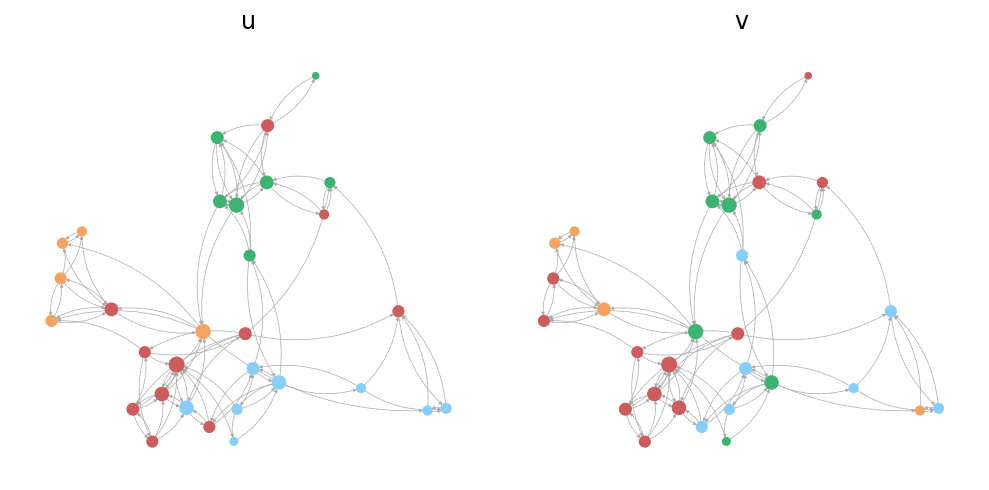

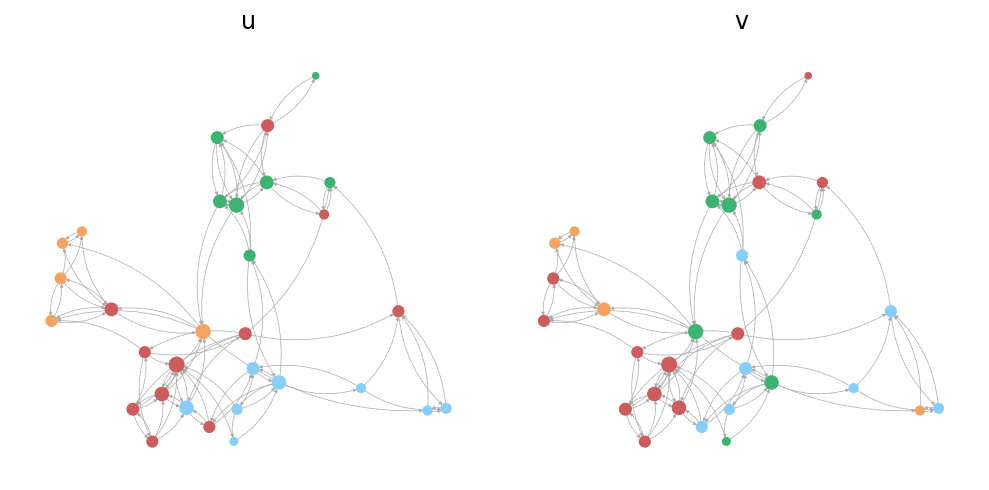

In [15]:
from pgm.output.plot import plot_hard_membership

plot_hard_membership(graph,
                     communities,
                     pos,
                     node_size,
                     colors,
                     edge_color)

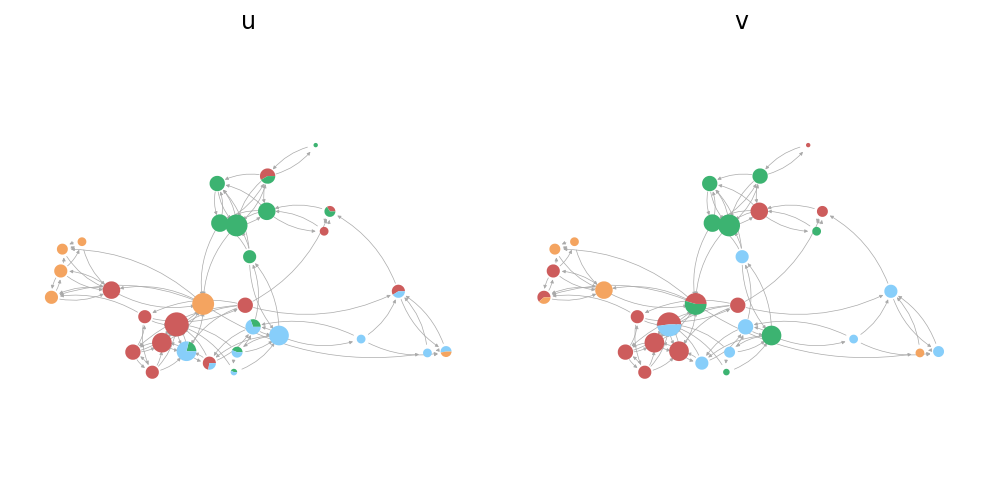

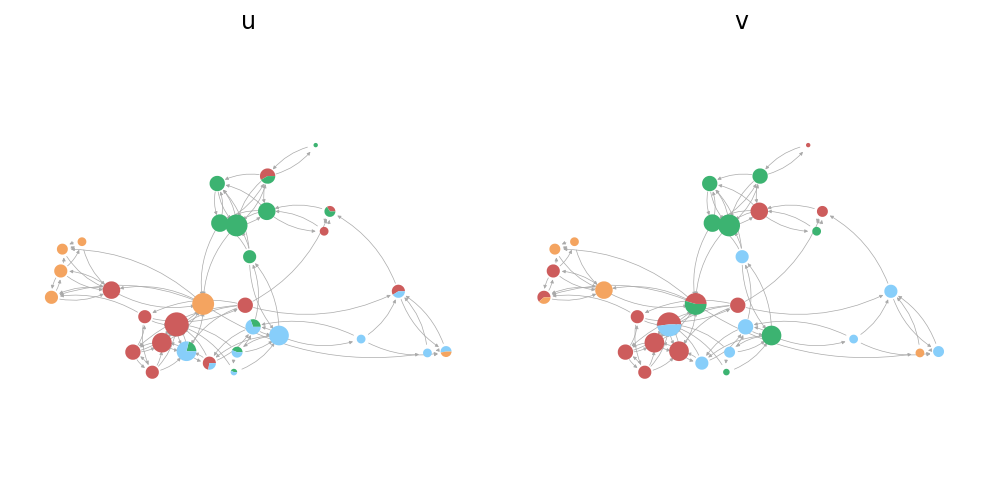

In [16]:
from pgm.output.plot import plot_soft_membership

plot_soft_membership(graph,
                     thetas,
                     pos,
                     node_size,
                     colors,
                     edge_color)

### Network reconstruction

In [17]:
from pgm.output.evaluate import expected_computation

Bdense = B.toarray()  # dense representation of the adjacency matrix

U, V, W, eta, maxL = parameters_jointcrep  # save the inferred parameters

# compute marginal and conditional expected value
M_marginal, M_conditional = expected_computation(B=Bdense, U=U, V=V, W=W, eta=eta)

##### Adjacency matrix

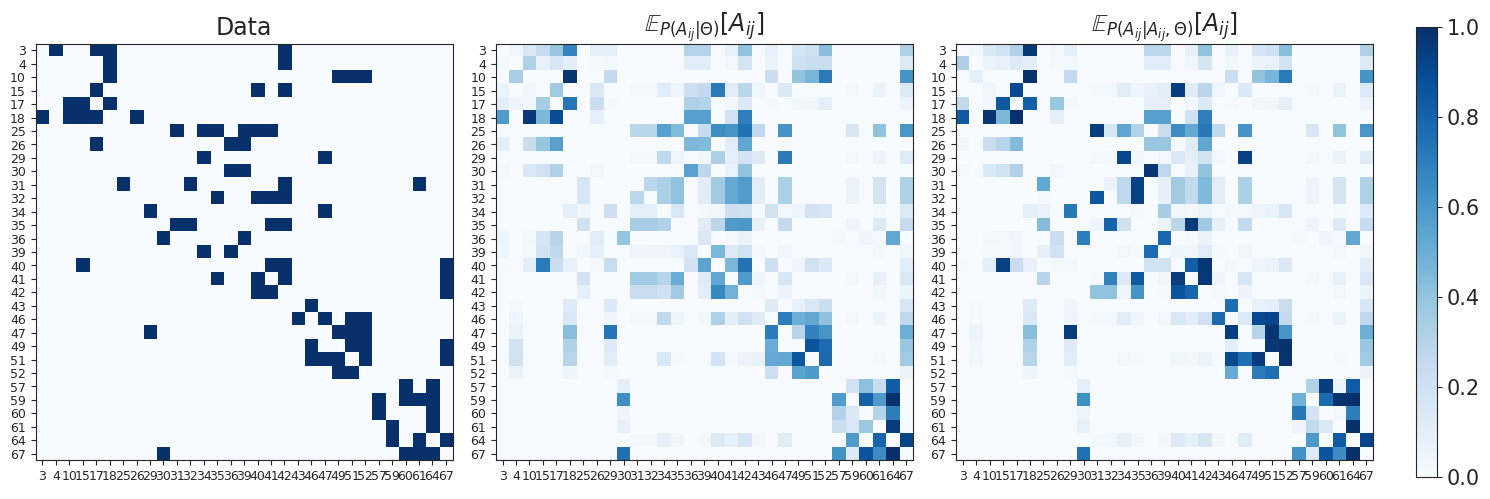

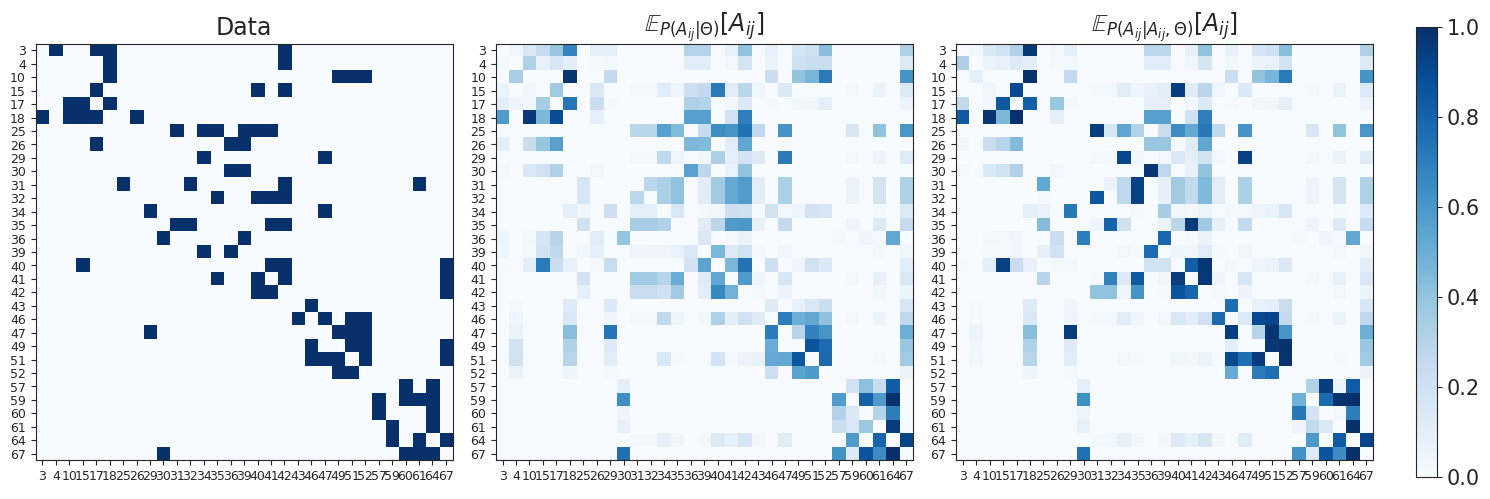

In [18]:
from pgm.output.plot import plot_adjacency

plot_adjacency(Bdense,
               M_marginal,
               M_conditional,
               nodes)

##### NetworkX graph

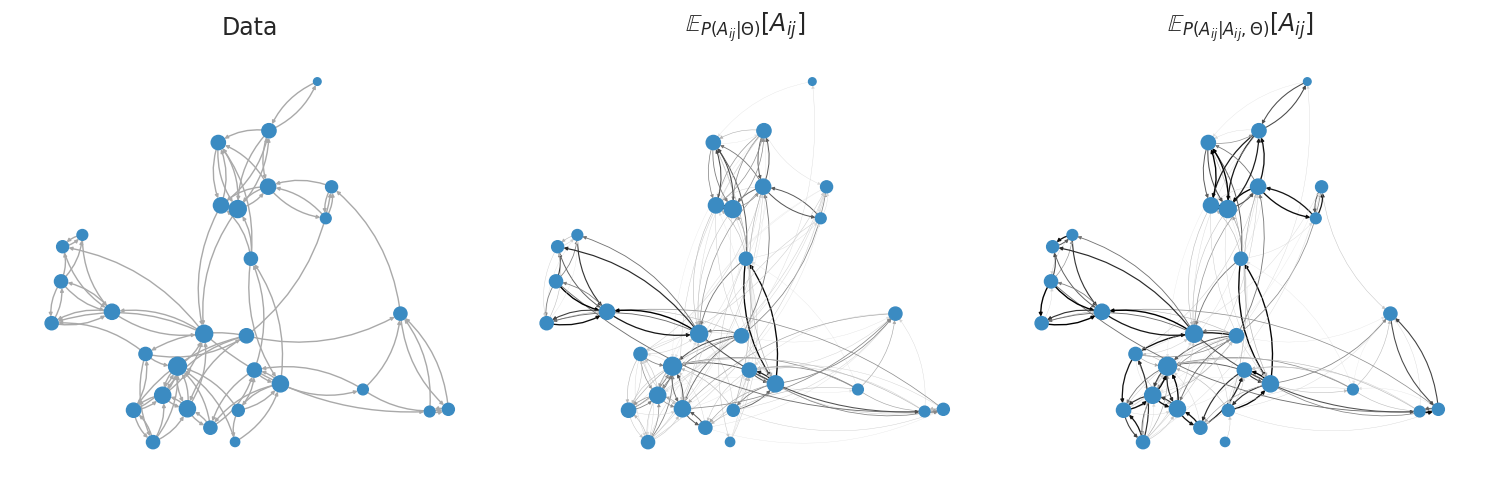

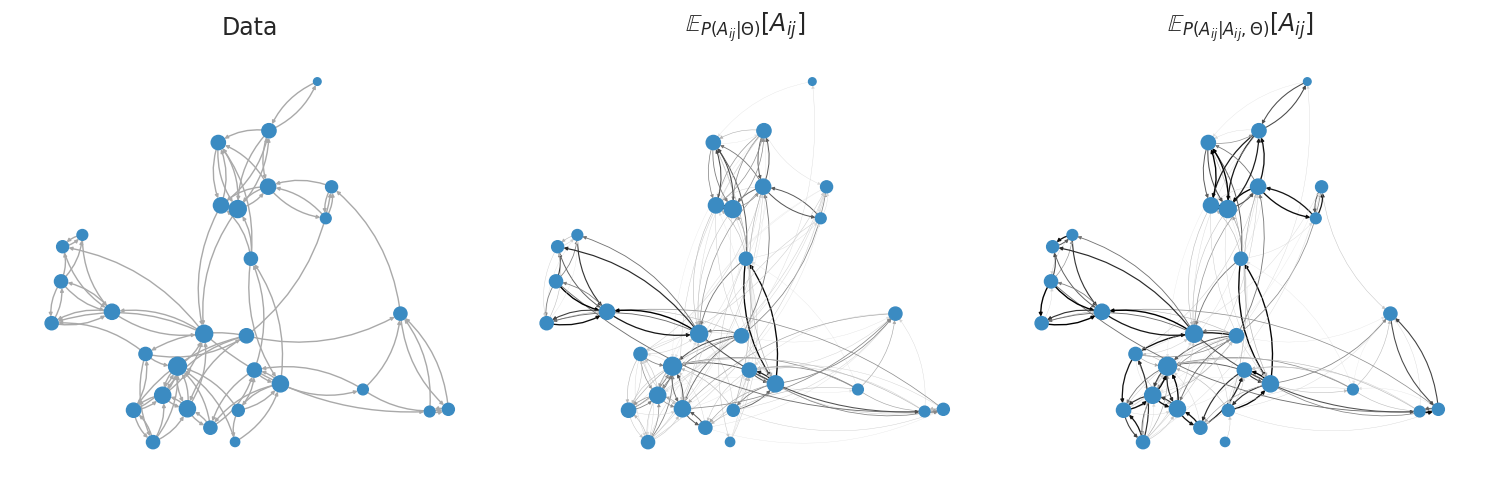

In [19]:
from pgm.output.plot import plot_graph

node_size = [graph.degree[i] * 15 for i in list(graph.nodes())]
plot_graph(graph, M_marginal, M_conditional, pos, node_size, node_color, edge_color)

##### Precision and recall of the joint distribution

In [20]:
from pgm.output.evaluate import compute_M_joint

# compute the joint probability for every pair of edges, i.e., the vector of probabilities p=[p00,p01,p10,p11]
p00, p01, p10, p11 = compute_M_joint(U=U, V=V, W=W, eta=eta)

In [21]:
# extract the inferred labels
N = len(nodes)
idx_upper = np.triu_indices(N, k=1)

inf_labels = [(0, 0), (0, 1), (1, 0), (1, 1)]
true_labels, pred_labels = [], []

for i, j in zip(*idx_upper):
    true_labels.append(inf_labels.index((int(Bdense[0, i, j]), int(Bdense[0, j, i]))))
    probs = [p00[0, i, j], p01[0, i, j], p10[0, i, j], p11[0, i, j]]
    probs /= sum(probs)
    pred_labels.append(np.argmax(probs))

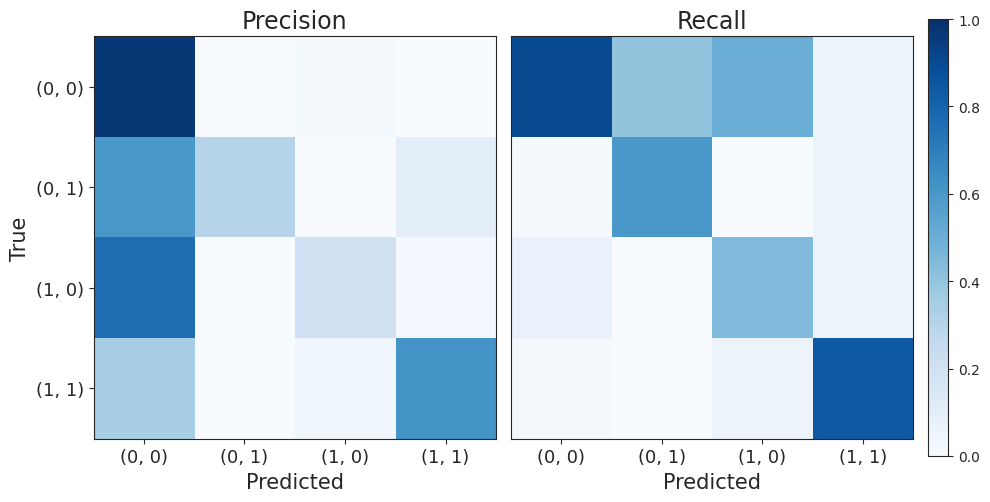

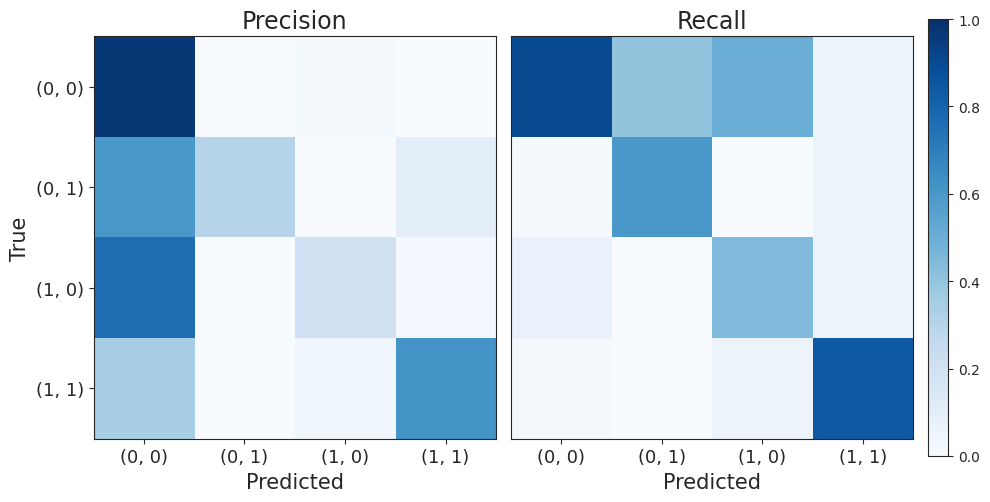

In [22]:
from pgm.output.plot import plot_precision_recall

# compute the confusion matrix between true and predicted labels and plot precision and recall
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, pred_labels)
plot_precision_recall(conf_matrix)

### Sampled networks

In [23]:
degrees = [graph.degree(n) for n in graph.nodes()]
k = np.mean(degrees)

In [24]:
from pgm.input.generate_network import ReciprocityMMSBM_joints

K = conf['K']
# generate five samples with different random seeds
Bsampled = []
np.random.seed(17)
rseed = np.random.randint(18)

for i in range(5):
    syn = ReciprocityMMSBM_joints(N=N, K=K, avg_degree=k, show_details=True, show_plots=False,
                                  eta=eta, parameters=[U, V, W], seed=rseed, output_net=False)
    Bsampled.append(syn.layer_graphs[0].toarray())

    rseed += np.random.randint(1, 18)

Number of edges and average degree in each layer:
E[0] = 100 - <k> = 6.452
Sparsity [0] = 0.104
Reciprocity (networkX) = 0.4
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.25

Number of edges and average degree in each layer:
E[0] = 101 - <k> = 6.516
Sparsity [0] = 0.105
Reciprocity (networkX) = 0.535
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.365

Number of edges and average degree in each layer:
E[0] = 100 - <k> = 6.452
Sparsity [0] = 0.104
Reciprocity (networkX) = 0.52
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.351

Number of edges and average degree in each layer:
E[0] = 97 - <k> = 6.258
Sparsity [0] = 0.101
Reciprocity (networkX) = 0.454
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.293

Number of edges and average degree in each layer:
E[0] = 90 - <k> = 5.806
Sparsity [0] = 0.094
Recipr

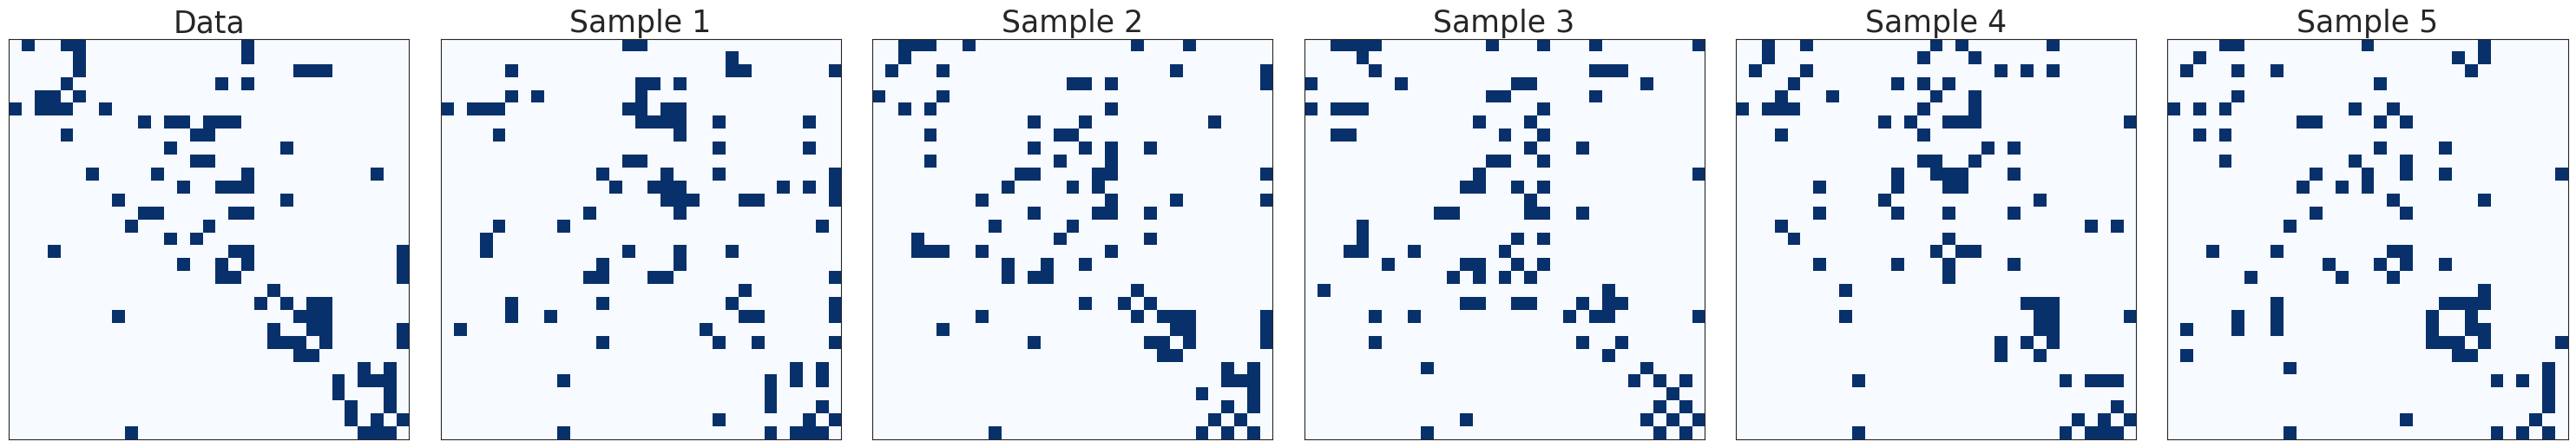

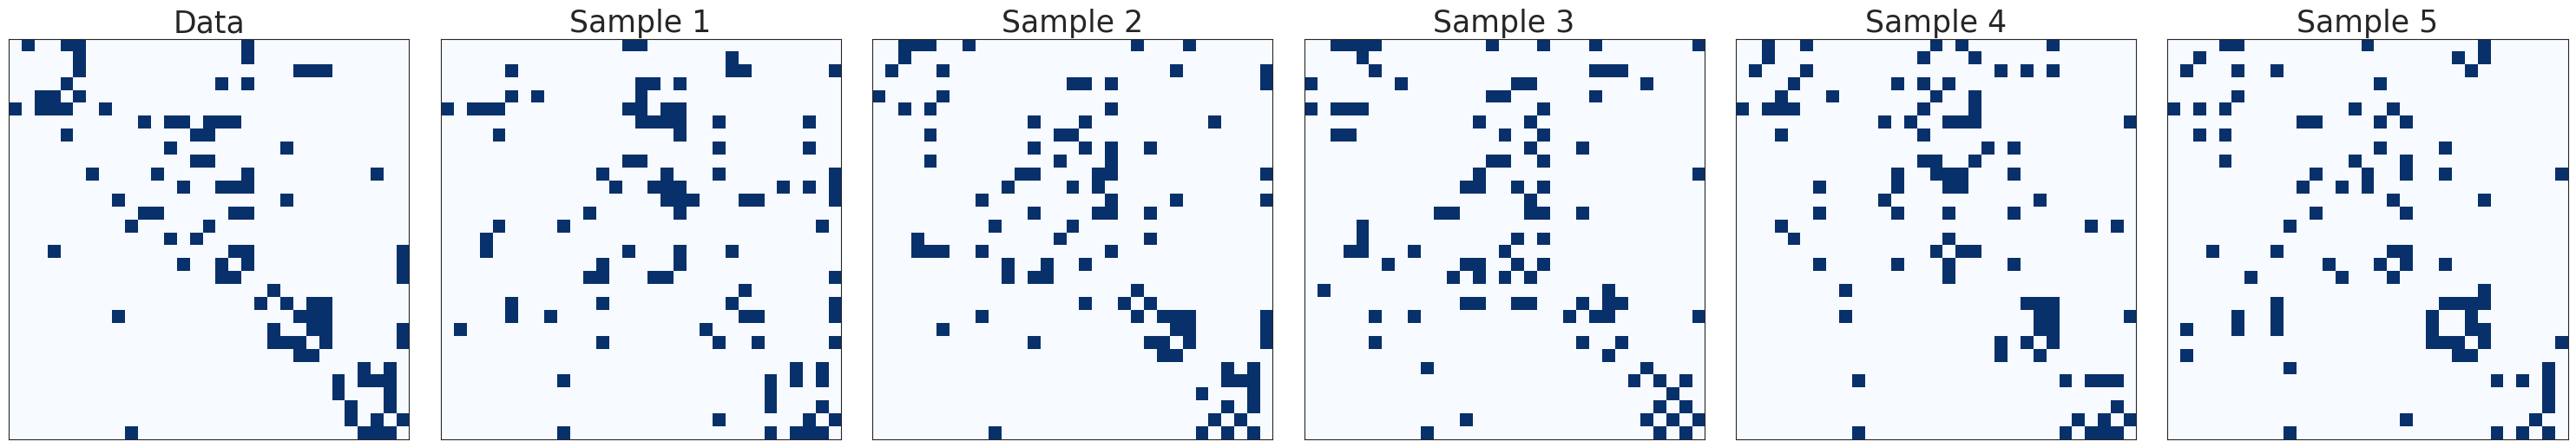

In [25]:
from pgm.output.plot import plot_adjacency_samples

plot_adjacency_samples(Bdense, Bsampled)